In [50]:
%matplotlib inline
from __future__ import print_function
import openpiv.process
import openpiv.filters
import openpiv.scaling
import openpiv.validation
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import animation, rc
from IPython.display import HTML
import numpy as np
import math
from PIL import Image
import tiffile as tiffile

def display(array):
    plt.imshow(array)
    plt.show()

indir = "/Volumes/HDD/Python_laboratory/Vector_visualizer/test"
outdir = "/Volumes/HDD/Python_laboratory/Vector_visualizer/test/out/"
testfile = "/Volumes/HDD/Python_laboratory/Vector_visualizer/test/sub.tif"

# PIV analysis

This is the analysis of PIV data on collectively migrating cells with H2B-mCherry. I hope to generate an number for the directional persistence and the migration speed in each time frame.

Let's first open a small testfile, in this case a subframe from a H2B-histone tagged HaCaT cell line migrating

In [51]:
with tiffile.TiffFile(testfile) as tif:
    arr = tif.asarray()
    arr = arr.astype(np.int32)

print(arr.shape)

(300, 263, 263)


The array is 263x263 and has 300 frames in one color channel. Let's look at the 60th frame:

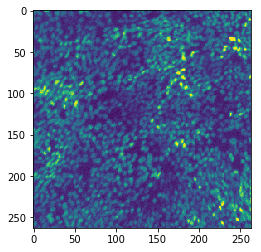

In [52]:
display(arr[59])


Now, lets have a look at it as an animation, as done [here](http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/).

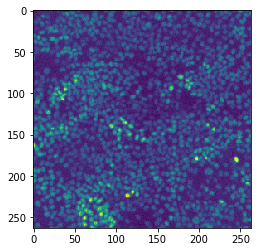

In [54]:
fig = plt.figure()

def get_frame(array, frame_index):
    return array[frame_index]

i = 0

im = plt.imshow(get_frame(arr, i), animated=True)


def updatefig(*args):
    global i
    global arr
    i += 1
    if i > arr.shape[0]:
        i = 0
    
    im.set_array(get_frame(arr, i))
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=10, blit=False)


In [55]:
HTML(ani.to_html5_video())

# PIV

Let's perform a PIV analysis on frames 60 & 61

In [ ]:
def arrayProcessor(arr, stopFrame, startFrame=0, frameSamplingInterval=1):

    assert stopFrame <= arr.shape[0]

    #PIV parameters
    window_size = 12
    overlap = 0
    search_area = window_size+4


    x, y = openpiv.process.get_coordinates(image_size=arr[0].shape, window_size=window_size, overlap=overlap)

    for frame in range(startFrame, stopFrame, frameSamplingInterval):
        print("Starting frame:", frame)
        if frame >= (stopFrame-1):
            break

        frame_a = arr[frame]
        frame_b = arr[frame+1]


        u, v, sig2noise = openpiv.process.extended_search_area_piv( frame_a, frame_b, window_size=window_size,
                                                                overlap=overlap,
                                                                dt=1, search_area_size=search_area,
                                                                sig2noise_method='peak2peak' )

        u, v, mask = openpiv.validation.sig2noise_val( u, v, sig2noise, threshold = 1.5)
        u, v = openpiv.filters.replace_outliers(u, v, method='localmean', kernel_size=2)